# Question 15

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.transforms import *
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import math

In [2]:
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.001
BATCH_INTERVAL = 100
TRAIN_SIZE = 50000
VALIDATION_SIZE = 10000

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

def get_dataloader(train_set, BATCH_SIZE):
    return torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

### Load data, set up train loader

Train and validation sets

In [4]:
train_32 = torchvision.datasets.ImageFolder(root = '../data/mnist-varres/32/train',
                                              transform=transform)
train_48 = torchvision.datasets.ImageFolder(root = '../data/mnist-varres/48/train',
                                              transform=transform)
train_64 = torchvision.datasets.ImageFolder(root = '../data/mnist-varres/64/train',
                                              transform=transform)

In [5]:
train_32, validation_32 = torch.utils.data.random_split(train_32, [math.floor(TRAIN_SIZE/(TRAIN_SIZE+VALIDATION_SIZE)*len(train_32)),
                                                                   math.ceil((1-TRAIN_SIZE/(TRAIN_SIZE+VALIDATION_SIZE))*len(train_32))])
train_48, validation_48 = torch.utils.data.random_split(train_48, [math.floor(TRAIN_SIZE/(TRAIN_SIZE+VALIDATION_SIZE)*len(train_48)),
                                                                    math.ceil((1-TRAIN_SIZE/(TRAIN_SIZE+VALIDATION_SIZE))*len(train_48))])
train_64, validation_64 = torch.utils.data.random_split(train_64, [math.floor(TRAIN_SIZE/(TRAIN_SIZE+VALIDATION_SIZE)*len(train_64)),
                                                                   math.ceil((1-TRAIN_SIZE/(TRAIN_SIZE+VALIDATION_SIZE))*len(train_64))])

In [6]:
print(f'Dataset\t| # Train + validation\t| #Train\t|#Validation',
      '\n------------------------------------------------------------',
      f'\n32x32\t| {len(train_32)+len(validation_32)}\t\t\t|{len(train_32)}\t\t|{len(validation_32)}',
      f'\n48x48\t| {len(train_48)+len(validation_48)}\t\t\t|{len(train_48)}\t\t|{len(validation_48)}',
      f'\n64x64\t| {len(train_64)+len(validation_64)}\t\t\t|{len(train_64)}\t\t|{len(validation_64)}')

Dataset	| # Train + validation	| #Train	|#Validation 
------------------------------------------------------------ 
32x32	| 19913			|16594		|3319 
48x48	| 20080			|16733		|3347 
64x64	| 20007			|16672		|3335


DataLoader

In [7]:
train_loader_32 = get_dataloader(train_32, BATCH_SIZE)
train_loader_48 = get_dataloader(train_48, BATCH_SIZE)
train_loader_64 = get_dataloader(train_64, BATCH_SIZE)

In [8]:
validation_loader_32 = get_dataloader(validation_32, BATCH_SIZE)
validation_loader_48 = get_dataloader(validation_48, BATCH_SIZE)
validation_loader_64 = get_dataloader(validation_64, BATCH_SIZE)

### Network architecture

In [9]:
class NetVariableSize(nn.Module):
    def __init__(self, input_channels, kernel, stride, padding, output, N):
        super(NetVariableSize, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel, stride, padding)  # size: batch, 1, 32, 32
        self.conv2 = nn.Conv2d(16, 32, kernel, stride, padding) # (batch, 16, 16, 16)
        self.conv3 = nn.Conv2d(32, N, kernel, stride, padding) # (batch, 32, 8, 8)
        self.fc1 = nn.Linear(N, output)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # (batch, 16, 28, 28)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # (batch, 32, 14, 14)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2) # (batch, N, 8, 8)
        x = F.max_pool2d(x, kernel_size = x.size()[2:]) # (batch, N, 4, 4)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim = 1)

#### Train with N=64

In [23]:
network = NetVariableSize(input_channels=3, kernel=3, stride=1, padding=1, output=10, N=64)
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

In [24]:
train_losses = []
train_counter = []
val_losses = []
val_counter = [i*TRAIN_SIZE for i in range(EPOCHS + 1)]
val_acc = []

In [25]:
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        output = network(data)
        
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % BATCH_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), '../results/model_Q15.pth')
            torch.save(optimizer.state_dict(), '../results/optimizer_Q15.pth')

In [26]:
def test(validation_loader, VALIDATION_SIZE):
    network.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            output = network(data)
            val_loss += F.cross_entropy(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        val_loss /= VALIDATION_SIZE
        val_losses.append(val_loss)
        val_acc.append(float(100. * correct / VALIDATION_SIZE))
        print('\nValidation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, VALIDATION_SIZE,
            100. * correct / VALIDATION_SIZE))

### Model testing and validation

In [27]:
train_loaders = {'32': train_loader_32,
                 '48': train_loader_48,
                 '64': train_loader_64
                }
validation_loaders = {'32': validation_loader_32,
                      '48': validation_loader_48,
                      '64': validation_loader_64
                     }

validation_size = {'32': len(validation_32),
                   '48': len(validation_48),
                   '64': len(validation_64)}

for epoch in range(1, EPOCHS + 1):
    print(f'EPOCH: {epoch}')
    for r in train_loaders.keys():
        print(f'\tRESOLUTION: {r}')
        train(epoch, train_loaders[r])
        test(validation_loaders[r], validation_size[r])

EPOCH: 1
	RESOLUTION: 32
Train Epoch: 1 [0/16594 (0%)]	Loss: 2.292394
Train Epoch: 1 [6400/16594 (38%)]	Loss: 0.328114
Train Epoch: 1 [12800/16594 (77%)]	Loss: 0.133483


/home/koen/anaconda3/envs/DLVU/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation set: Avg. loss: 0.2089, Accuracy: 3112/3319 (94%)

	RESOLUTION: 48
Train Epoch: 1 [0/16733 (0%)]	Loss: 0.160598
Train Epoch: 1 [6400/16733 (38%)]	Loss: 0.147115
Train Epoch: 1 [12800/16733 (76%)]	Loss: 0.117190

Validation set: Avg. loss: 0.1723, Accuracy: 3177/3347 (95%)

	RESOLUTION: 64
Train Epoch: 1 [0/16672 (0%)]	Loss: 0.279562
Train Epoch: 1 [6400/16672 (38%)]	Loss: 0.276717
Train Epoch: 1 [12800/16672 (77%)]	Loss: 0.188822

Validation set: Avg. loss: 0.1024, Accuracy: 3229/3335 (97%)

EPOCH: 2
	RESOLUTION: 32
Train Epoch: 2 [0/16594 (0%)]	Loss: 0.030425
Train Epoch: 2 [6400/16594 (38%)]	Loss: 0.021492
Train Epoch: 2 [12800/16594 (77%)]	Loss: 0.026305

Validation set: Avg. loss: 0.0899, Accuracy: 3228/3319 (97%)

	RESOLUTION: 48
Train Epoch: 2 [0/16733 (0%)]	Loss: 0.084972
Train Epoch: 2 [6400/16733 (38%)]	Loss: 0.011639
Train Epoch: 2 [12800/16733 (76%)]	Loss: 0.041997

Validation set: Avg. loss: 0.0947, Accuracy: 3246/3347 (97%)

	RESOLUTION: 64
Train Epoch: 2 [0/16

In [28]:
# Store values
np.savetxt("../results/resolutions_n64_training_stats.csv", [p for p in zip(train_counter, train_losses)], delimiter=',', fmt='%s')
np.savetxt("../results/resolutions_n64_validation_stats.csv", [p for p in zip(val_counter, val_losses, val_acc)], delimiter=',', fmt='%s')

### Deriving N for network

**Question 15**: Note that if we set N=64, as we did for the fixed resolution network the last
linear layer has fewer parameters here than it did in the first one. Either by trial and error, or
through computing the parameters, find the value of N for which both networks have roughly
the same number of parameters (this will allow us to fairly compare their performances).

- ```model.parameters()``` loops over all parameters tensors of a network. Just multiply all
dimensions of these tensors, and sum the result.
- Note that the input resolution doesn't affect the number of parameters of the model.

In [29]:
class NetFixedSize(nn.Module):
    def __init__(self, input_channels, kernel, stride, padding, output):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel, stride, padding) # size: batch, 1, 28, 28
        self.conv2 = nn.Conv2d(16, 32, kernel, stride, padding) # (batch, 16, 14, 14)
        self.conv3 = nn.Conv2d(32, 64, kernel, stride, padding) # (batch, 32, 7, 7)
        self.fc1 = nn.Linear(64*3*3, output)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # (batch, 16, 28, 28) # TODO klopt het dat relu en maxpool zijn omgedraaid?
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # (batch, 32, 14, 14)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2) # (batch, 64, 7, 7)
        x = torch.flatten(x, 1) # (batch, 64, 3, 3)
        x = self.fc1(x)
        return F.log_softmax(x, dim = 1)

In [30]:
network_FS = NetFixedSize(input_channels = 3, kernel = 3, stride = 1, padding = 1, output = 10)

In [31]:
def get_n_params(model):
    """ Code sample from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/7 """
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [32]:
n_params_fixed_size = get_n_params(network_FS)
print(n_params_fixed_size)

29354


N=64, n_params=24234
N=65, n_params=24533
N=66, n_params=24832
N=67, n_params=25131
N=68, n_params=25430
N=69, n_params=25729
N=70, n_params=26028
N=71, n_params=26327
N=72, n_params=26626
N=73, n_params=26925
N=74, n_params=27224
N=75, n_params=27523
N=76, n_params=27822
N=77, n_params=28121
N=78, n_params=28420
N=79, n_params=28719
N=80, n_params=29018
N=81, n_params=29317
N=82, n_params=29616
N=83, n_params=29915


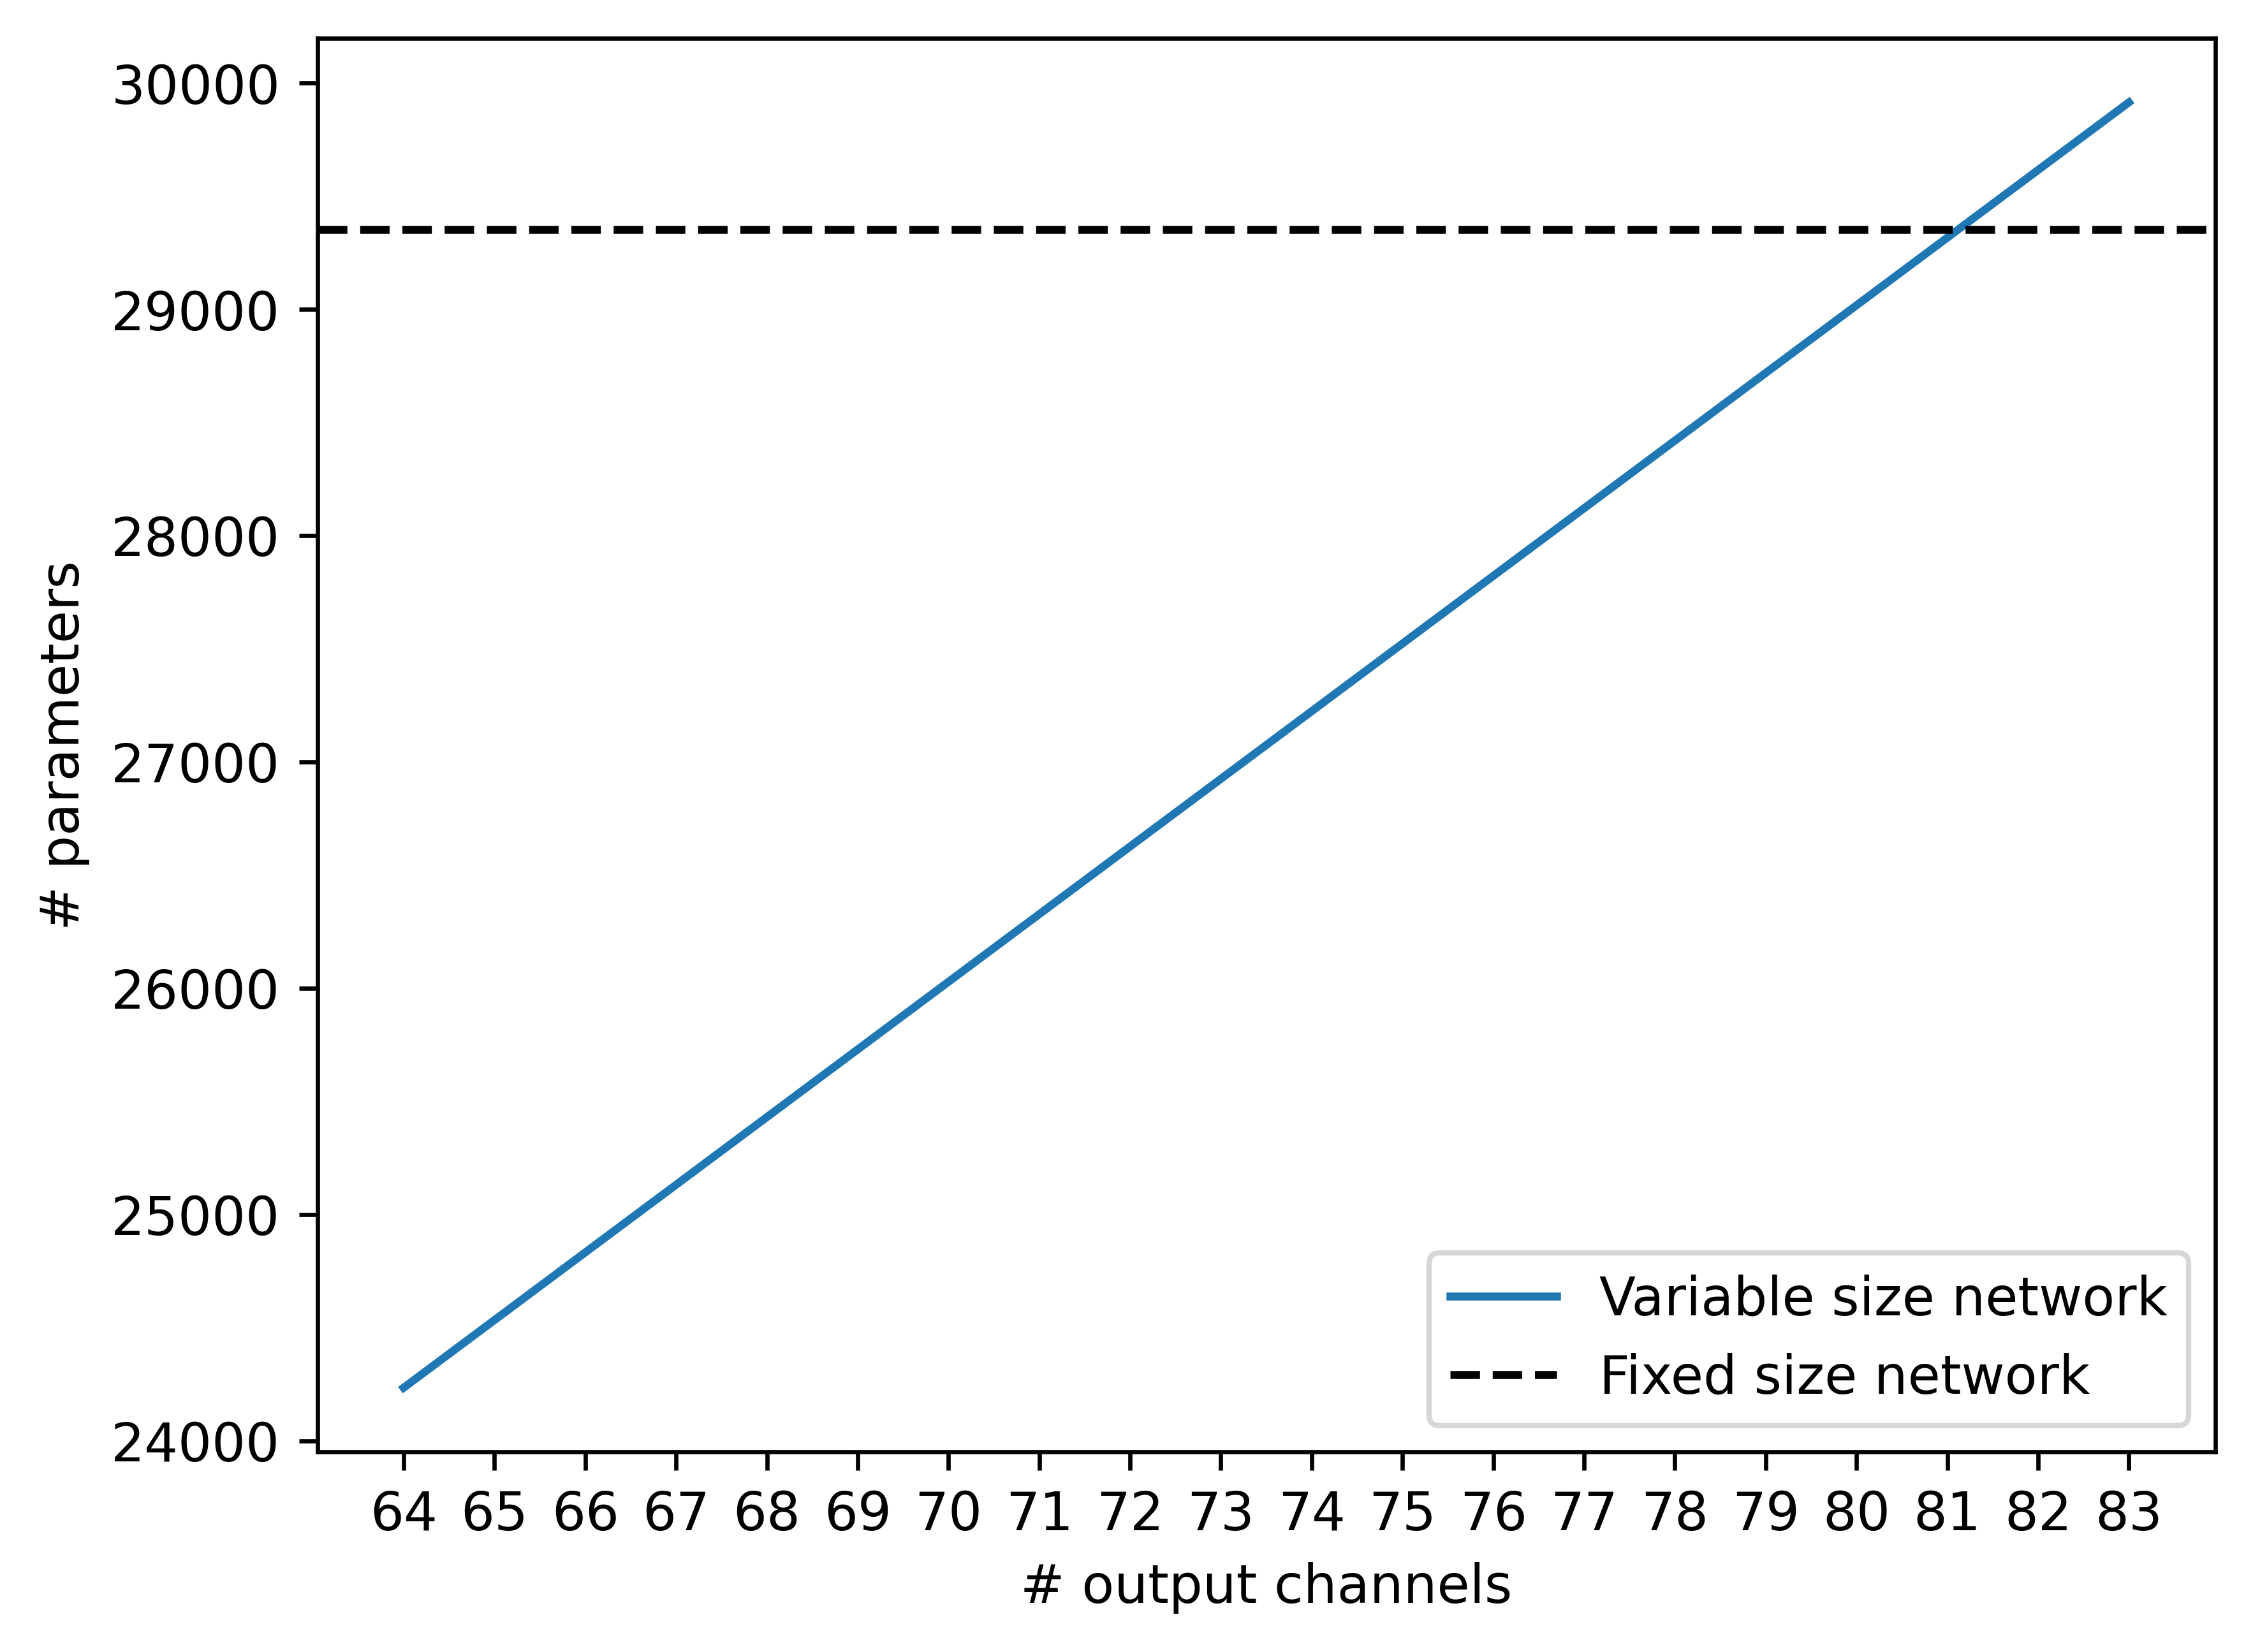

In [33]:
iter_n = []
iter_params = []

for n in range(64, 64+20):
    network_VS = NetVariableSize(input_channels=3, kernel=3, stride=1, padding=1, output=10, N=n)
    n_params = get_n_params(network_VS)
    iter_n.append(n)
    iter_params.append(n_params)
    print(f'N={n}, n_params={n_params}')
    
import matplotlib.pyplot as plt

plt.figure(dpi=600)
plt.plot(list(range(64,84)), iter_params, label = 'Variable size network')
plt.xlabel('# output channels')
plt.ylabel('# parameters')
plt.xticks(list(range(64,84)))
plt.axhline(n_params_fixed_size, color='black', linestyle='--', label = 'Fixed size network')
plt.legend()


#### Train with N=81

In [34]:
network = NetVariableSize(input_channels=3, kernel=3, stride=1, padding=1, output=10, N=81)
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

In [40]:
train_losses = []
train_counter = []
val_losses = []
val_counter = [i*TRAIN_SIZE for i in range(EPOCHS + 1)]
val_acc = []

In [41]:
train_loaders = {'32': train_loader_32,
                 '48': train_loader_48,
                 '64': train_loader_64
                }
validation_loaders = {'32': validation_loader_32,
                      '48': validation_loader_48,
                      '64': validation_loader_64
                     }

validation_size = {'32': len(validation_32),
                   '48': len(validation_48),
                   '64': len(validation_64)}

for epoch in range(1, EPOCHS + 1):
    print(f'EPOCH: {epoch}')
    for r in train_loaders.keys():
        print(f'\tRESOLUTION: {r}')
        train(epoch, train_loaders[r])
        test(validation_loaders[r], validation_size[r])

EPOCH: 1
	RESOLUTION: 32
Train Epoch: 1 [0/16594 (0%)]	Loss: 0.022830
Train Epoch: 1 [6400/16594 (38%)]	Loss: 0.038066
Train Epoch: 1 [12800/16594 (77%)]	Loss: 0.058417

Validation set: Avg. loss: 0.0704, Accuracy: 3239/3319 (98%)

	RESOLUTION: 48
Train Epoch: 1 [0/16733 (0%)]	Loss: 0.014187
Train Epoch: 1 [6400/16733 (38%)]	Loss: 0.073917
Train Epoch: 1 [12800/16733 (76%)]	Loss: 0.012603

Validation set: Avg. loss: 0.0660, Accuracy: 3282/3347 (98%)

	RESOLUTION: 64
Train Epoch: 1 [0/16672 (0%)]	Loss: 0.019145
Train Epoch: 1 [6400/16672 (38%)]	Loss: 0.028585
Train Epoch: 1 [12800/16672 (77%)]	Loss: 0.289114

Validation set: Avg. loss: 0.0494, Accuracy: 3289/3335 (99%)

EPOCH: 2
	RESOLUTION: 32
Train Epoch: 2 [0/16594 (0%)]	Loss: 0.018859
Train Epoch: 2 [6400/16594 (38%)]	Loss: 0.068677
Train Epoch: 2 [12800/16594 (77%)]	Loss: 0.011861

Validation set: Avg. loss: 0.0629, Accuracy: 3246/3319 (98%)

	RESOLUTION: 48
Train Epoch: 2 [0/16733 (0%)]	Loss: 0.078366
Train Epoch: 2 [6400/16733 (3

In [42]:
# Store values
np.savetxt("../results/resolutions_n81_training_stats.csv", [p for p in zip(train_counter, train_losses)], delimiter=',', fmt='%s')
np.savetxt("../results/resolutions_n81_validation_stats.csv", [p for p in zip(val_counter, val_losses, val_acc)], delimiter=',', fmt='%s')

# Question 16

"Compare the validation performance of global max pooling to that of global mean pooling. Report your findings, and choose a global pooling variant."

From **Question 11** we got the lines of code to either apply global _max_ or _mean_ pooling:

```maxpool = torch.nn.MaxPool2d(kernel_size, stride)```

```meanpool = torch.nn.AvgPool2d(kernel_size, stride)```

Here, we adapt _Net()_ to apply global _mean_ pooling for the network structure given in Question 15.

In [49]:
class NetMeanPool(nn.Module):
    def __init__(self, input_channels, kernel, stride, padding, output, N):
        super(NetMeanPool, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel, stride, padding)  # size: batch, 1, 32, 32
        self.conv2 = nn.Conv2d(16, 32, kernel, stride, padding) # (batch, 16, 16, 16)
        self.conv3 = nn.Conv2d(32, N, kernel, stride, padding) # (batch, 32, 8, 8)
        self.fc1 = nn.Linear(N, output)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # (batch, 16, 28, 28)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # (batch, 32, 14, 14)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2) # (batch, N, 8, 8)
        x = F.avg_pool2d(x, kernel_size = x.size()[2:]) # (batch, N, 4, 4)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim = 1)

In [50]:
network = NetMeanPool(input_channels=3, kernel=3, stride=1, padding=1, output=10, N=81)
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

In [52]:
train_losses = []
train_counter = []
val_losses = []
val_acc = []

In [53]:
for epoch in range(1, EPOCHS + 1):
    print(f'EPOCH: {epoch}')
    for r in train_loaders.keys():
        print(f'\tRESOLUTION: {r}')
        train(epoch, train_loaders[r])
        test(validation_loaders[r], validation_size[r])

EPOCH: 1
	RESOLUTION: 32
Train Epoch: 1 [0/16594 (0%)]	Loss: 2.316800
Train Epoch: 1 [6400/16594 (38%)]	Loss: 1.493577
Train Epoch: 1 [12800/16594 (77%)]	Loss: 0.777044


/home/koen/anaconda3/envs/DLVU/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Validation set: Avg. loss: 0.5216, Accuracy: 2796/3319 (84%)

	RESOLUTION: 48
Train Epoch: 1 [0/16733 (0%)]	Loss: 1.966870
Train Epoch: 1 [6400/16733 (38%)]	Loss: 0.614289
Train Epoch: 1 [12800/16733 (76%)]	Loss: 0.242850

Validation set: Avg. loss: 0.4032, Accuracy: 2946/3347 (88%)

	RESOLUTION: 64
Train Epoch: 1 [0/16672 (0%)]	Loss: 1.072630
Train Epoch: 1 [6400/16672 (38%)]	Loss: 0.496554
Train Epoch: 1 [12800/16672 (77%)]	Loss: 0.256754

Validation set: Avg. loss: 0.3467, Accuracy: 3011/3335 (90%)

EPOCH: 2
	RESOLUTION: 32
Train Epoch: 2 [0/16594 (0%)]	Loss: 1.271944
Train Epoch: 2 [6400/16594 (38%)]	Loss: 0.489305
Train Epoch: 2 [12800/16594 (77%)]	Loss: 0.353840

Validation set: Avg. loss: 0.2222, Accuracy: 3094/3319 (93%)

	RESOLUTION: 48
Train Epoch: 2 [0/16733 (0%)]	Loss: 0.240674
Train Epoch: 2 [6400/16733 (38%)]	Loss: 0.249134
Train Epoch: 2 [12800/16733 (76%)]	Loss: 0.177738

Validation set: Avg. loss: 0.2203, Accuracy: 3130/3347 (94%)

	RESOLUTION: 64
Train Epoch: 2 [0/16

In [76]:
maxpool_train_loss = np.genfromtxt("../results/resolutions_n81_training_stats.csv", delimiter=',')[:,1]
maxpool_val_loss = np.genfromtxt("../results/resolutions_n81_validation_stats.csv", delimiter=',')[:,1]
maxpool_val_acc = np.genfromtxt("../results/resolutions_n81_validation_stats.csv", delimiter=',')[:,2]

/tmp/ipykernel_64216/3802961999.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=10)


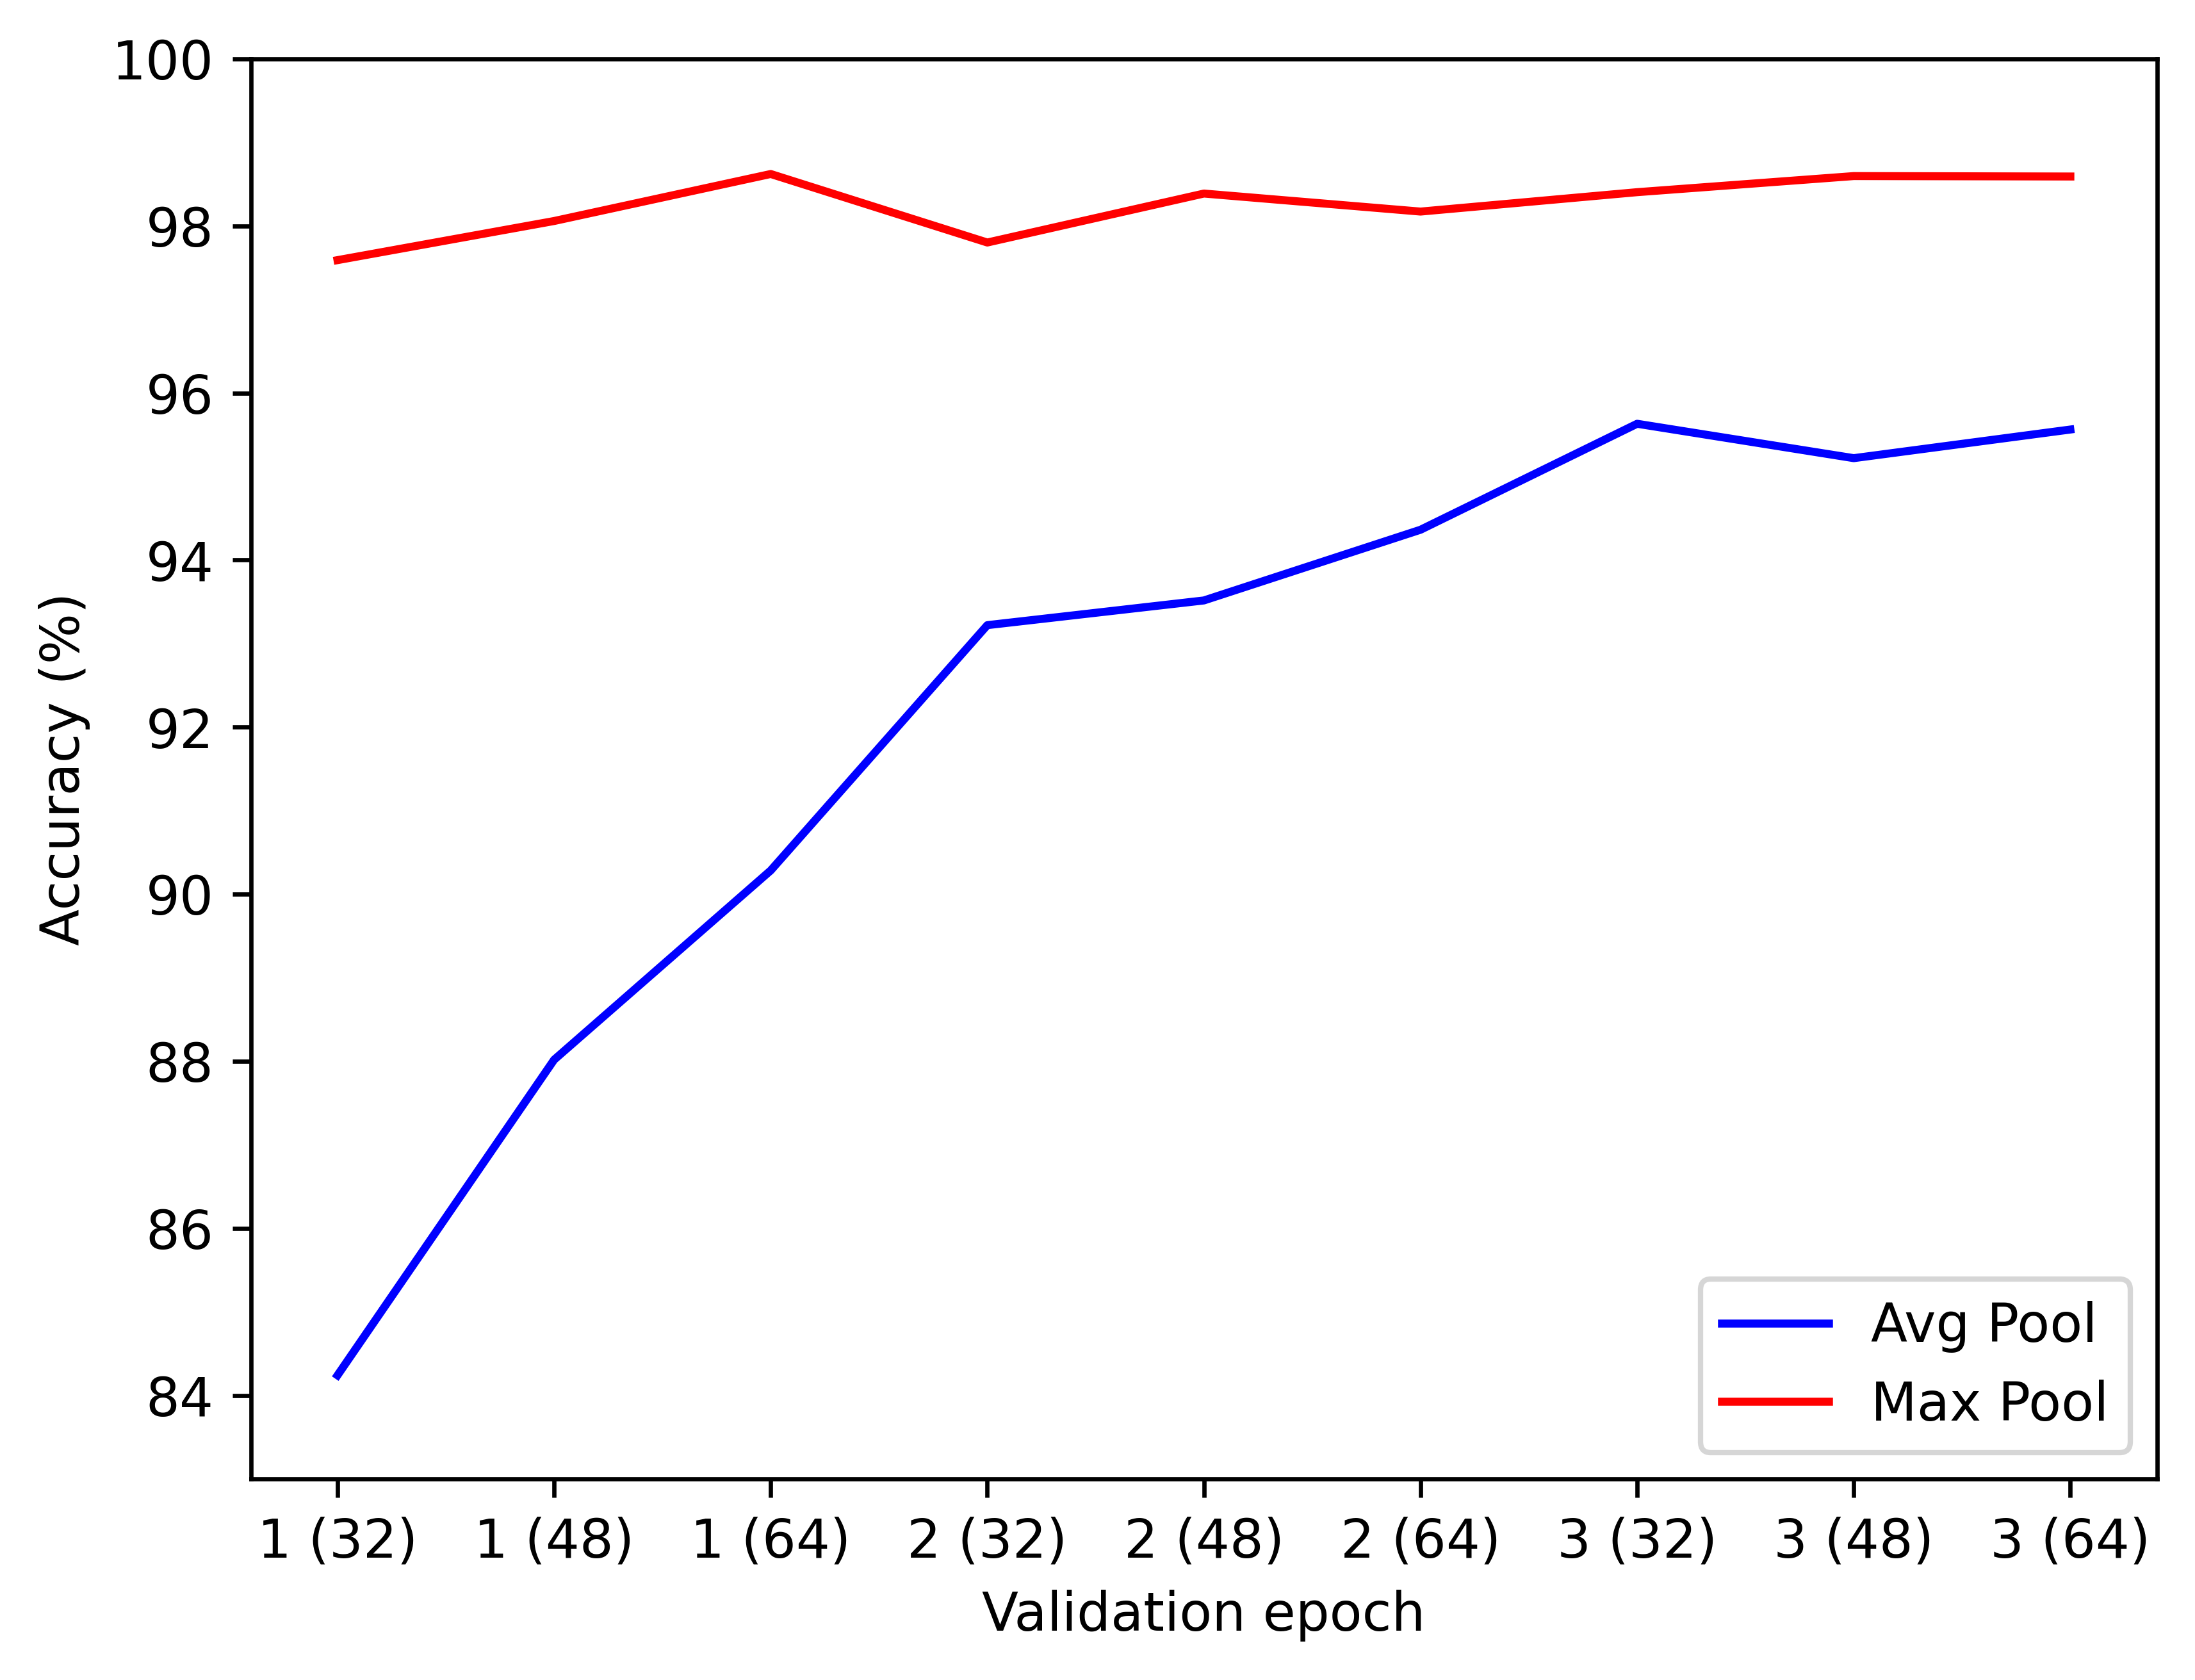

In [131]:
fig, ax = plt.subplots(1,1, dpi = 600) 
ax.plot(val_acc, label = 'Avg Pool', color = 'b')
ax.plot(maxpool_val_acc, label = 'Max Pool', color = 'r')
x_ticks_labels = ['','1 (32)','1 (48)','1 (64)','2 (32)','2 (48)','2 (64)','3 (32)','3 (48)', '3 (64)']
ax.set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=10)
ax.set_ylim(83,100)
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Validation epoch')
ax.legend()

/tmp/ipykernel_64216/355713182.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=10)


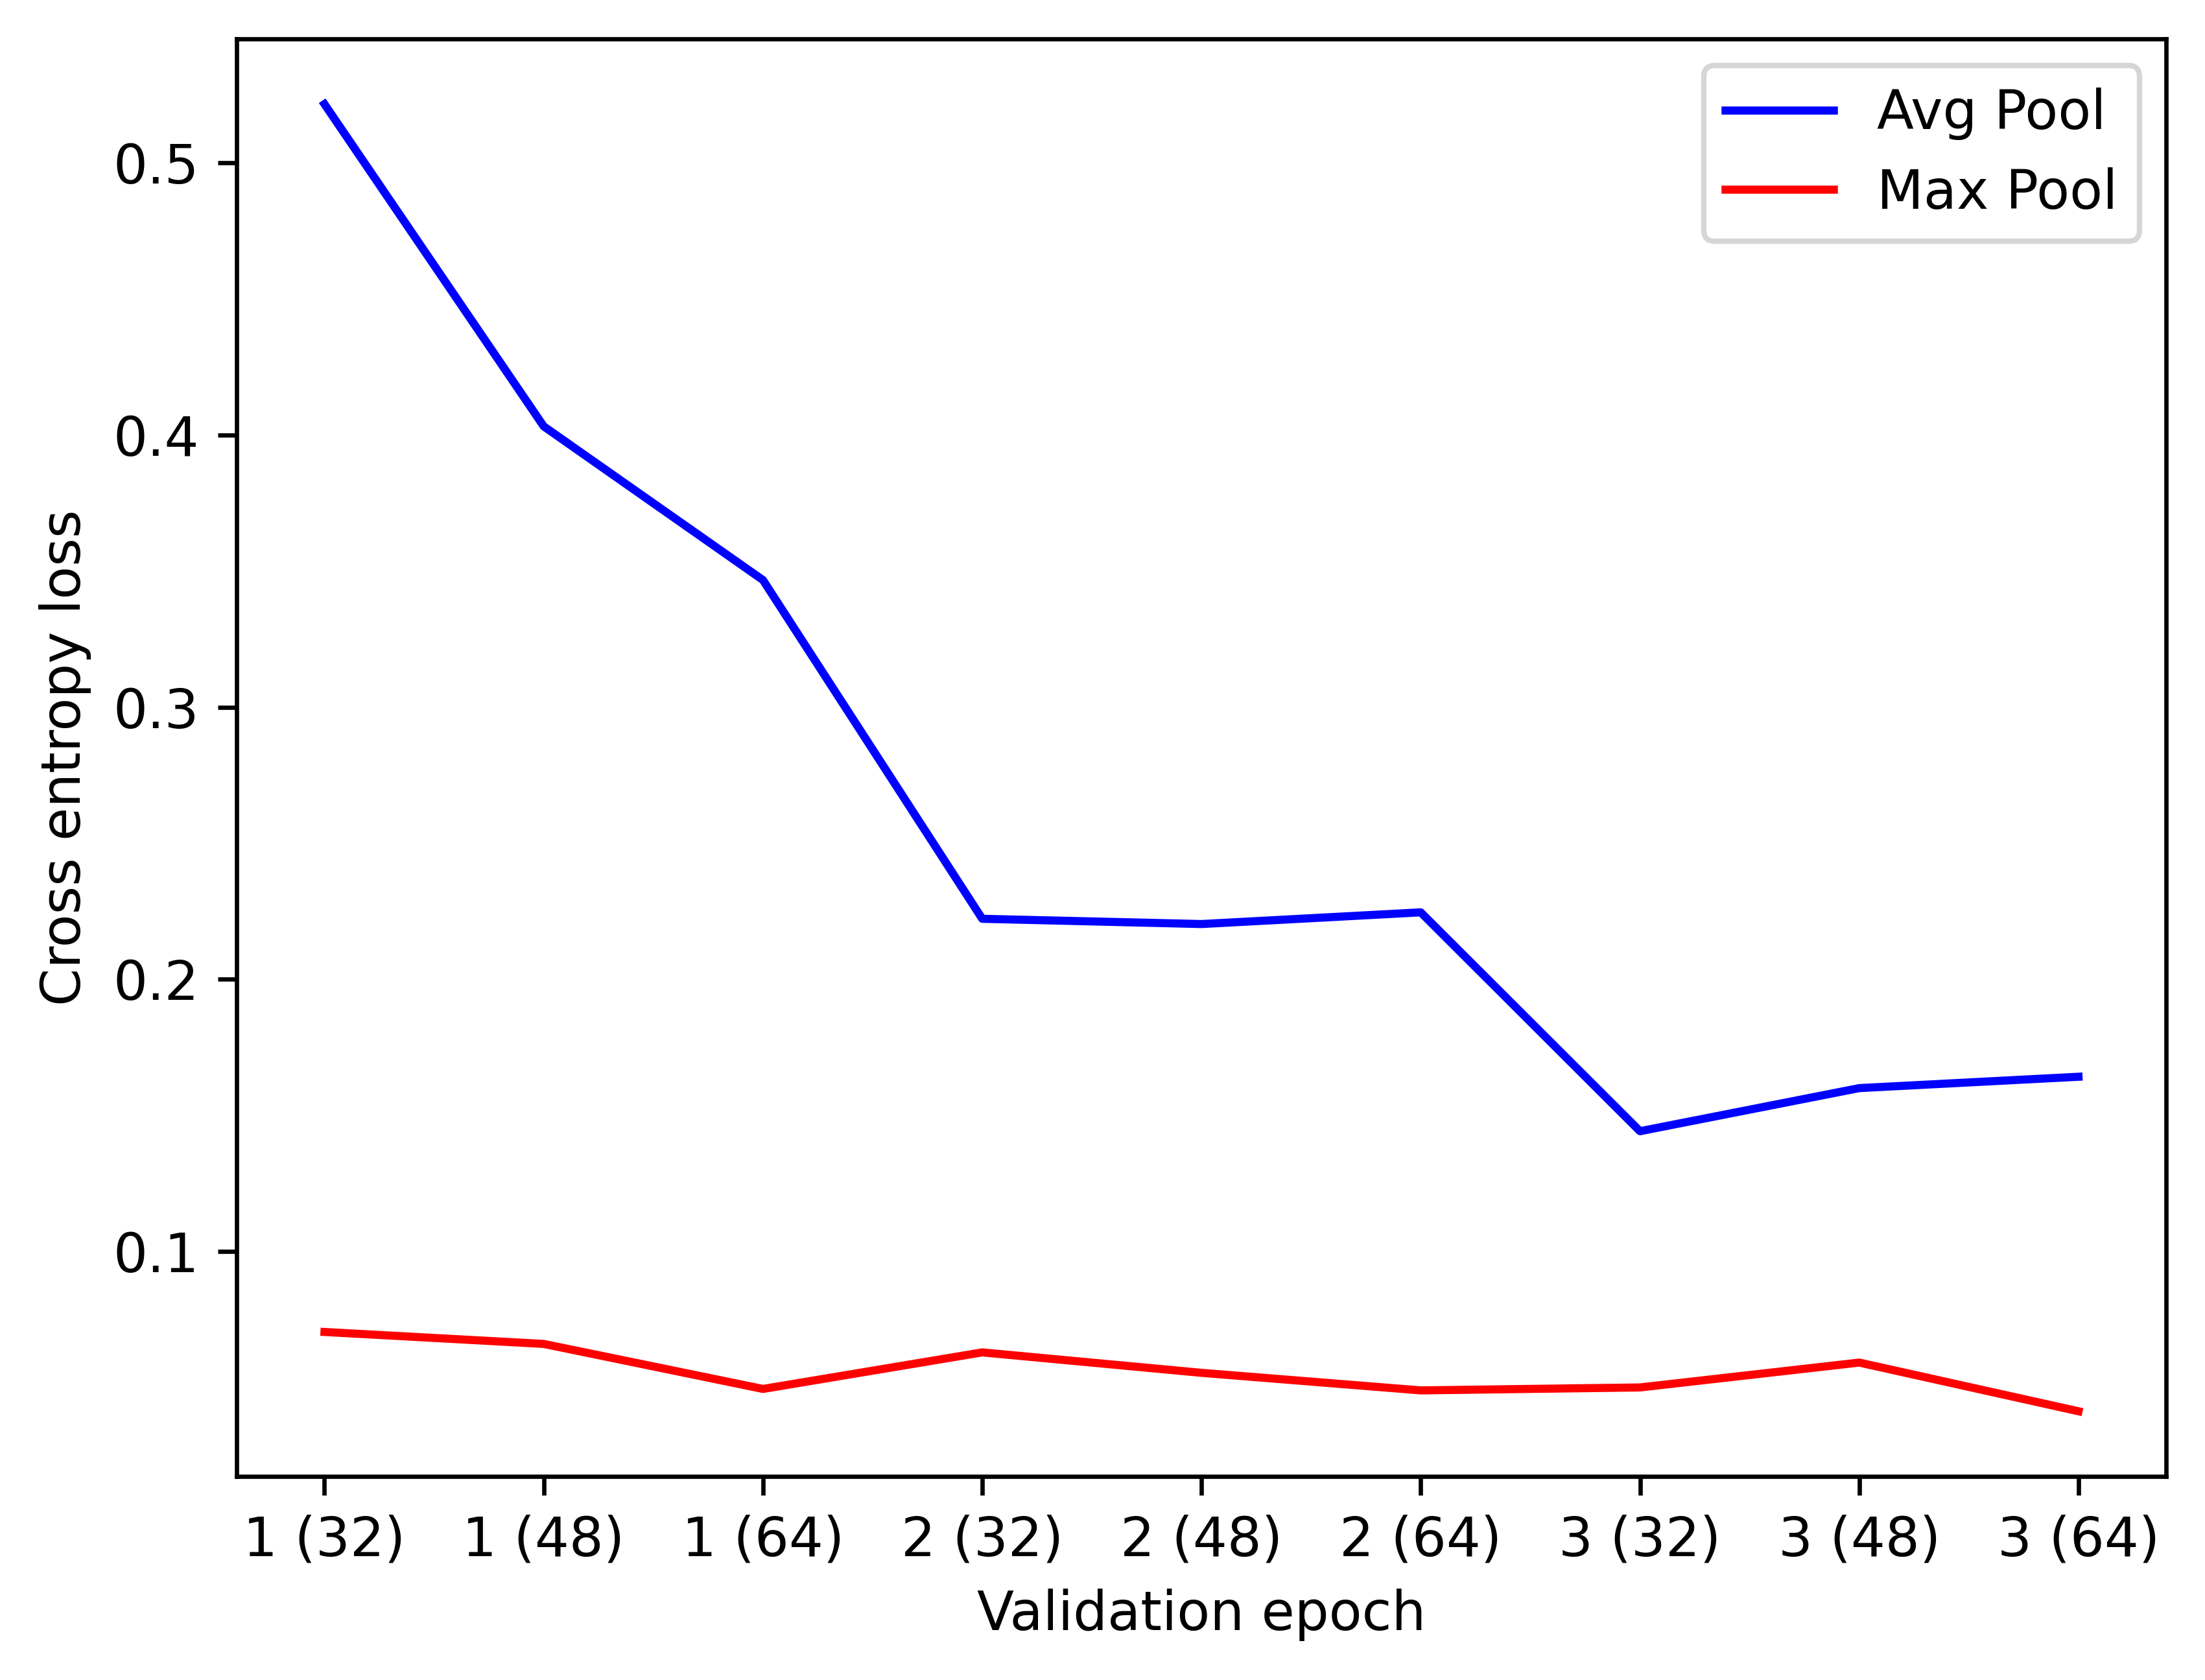

In [139]:
fig, ax = plt.subplots(1,1, dpi = 600) 
ax.plot(val_losses, label = 'Avg Pool', color = 'b')
ax.plot(maxpool_val_loss, label = 'Max Pool', color = 'r')
x_ticks_labels = ['','1 (32)','1 (48)','1 (64)','2 (32)','2 (48)','2 (64)','3 (32)','3 (48)', '3 (64)']
ax.set_xticklabels(x_ticks_labels, rotation='horizontal', fontsize=10)
#ax.set_ylim(83,100)
ax.set_ylabel('Cross entropy loss')
ax.set_xlabel('Validation epoch')
ax.legend()

### Evaluation
Based on these results, we choose for the **global MAX pooling**.